# Fraud Detection in Bank Transactions

## Orkhan Amrullayev

In this paper, bank transactions will be used to predict fraudulent ones. 

As per description of the dataset, it contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

This paper will compare various data balancing techniques with powerful boosting models. Models used here are Random Forest, XGBoost and LGB. We will look at precision-recall curve and roc curve.

## Content

### 1. Imports and reading dataset
### 2. Exploratory Data Analysis
### 3. Dealing with unbalanced dataset
 3.1 Without balancing
 
 3.2 Undersampling
 
 3.3 Oversampling
### 4. Building function for 3 models:
 4.1 Random forest classifier
 
 4.2 XGBoost
 
 4.3 LightGBM
 
### 5. Comparison of result of the models with "Without balancing", "Undersampling", "Oversampling" options
### 6. Conclusion

In [1]:
import os
print(os.listdir("../input"))

['creditcard.csv']


Importing the libraries for the further use.

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Reading the dataset.

In [3]:
df = pd.read_csv("../input/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Checking if there is missing values in our data set. If we have we should either clear them or impute them according to their amount and distribution according to:
- Missing At Random (MAR) — because the reason why a random value is missing from a feature (predictor) or target can be understood from the exploratory data analysis itself. (Read about this in-depth here)
- Missing Completely At Random (MCAR) — there is nothing fishy, the missing is absolutely random! (Read about this in-depth here)
- Missing Not At Random (MNAR) — the most unfortunate situation for a machine learning enthusiast or student because the reason for missing here can be explained but not with the help of variables you have in your dataset. This situation demands a thorough investigation into the initial phase of the data analytics — data collection! (Read about this in-depth here)

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Apparently our data set does not contain any missing value.

Visualizing the dataset by time (in seconds) to see the common patterns between fraudulent and non-fraudulent transactions in terms of time.

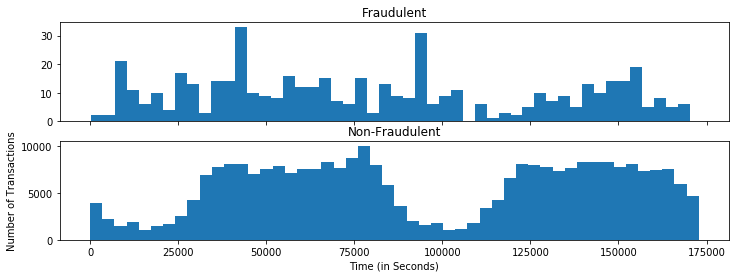

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Time[df.Class == 1], bins = 50)
ax1.set_title("Fraudulent")
ax2.hist(df.Time[df.Class == 0], bins = 50)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

Then visualizing the dataset by amount (in US dollars) to see the common patterns between fraudulent and non-fraudulent transactions in terms of transaction amount.

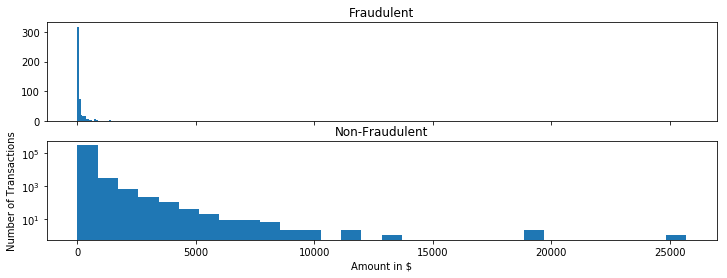

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Amount[df.Class == 1], bins = 30)
ax1.set_title("Fraudulent")
ax2.hist(df.Amount[df.Class == 0], bins = 30)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Amount in $')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Amount variable is highly skewed. So we will standardize it with mean = 0 and sd = 1 in order to have better results.

In [8]:
df["Normalized_Amount"] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#Drop time & amount variable
df = df.drop(['Time', 'Amount'], axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


# Dealing with unbalanced dataset

Checking if our dataset is balanced or unbalanced.

In [9]:
Class = [len(df.loc[df.Class == 1]), len(df.loc[df.Class == 0])]
pd.Series(Class, index = ['Fraudulent', 'Non-fraudulent'], name = 'target')

Fraudulent           492
Non-fraudulent    284315
Name: target, dtype: int64

Visualizing the fraud and legit transactions by their amounts

Text(0,0.5,'Frequency')

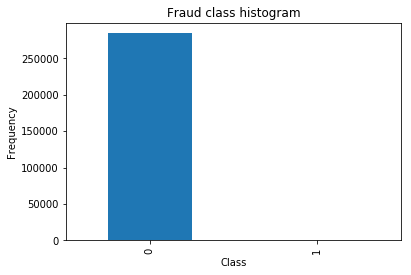

In [10]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [11]:
#Percentage of minority(fraudulent) class
print('% of Fraudulent Class = {:.3f}%'.format(len(df[df.Class == 1])*100 / len(df)))

% of Fraudulent Class = 0.173%


Our data is highly unbalanced with roughly 998:2 proportion.

So we need to make it balanced or close to balanced data because we should give equal priority to each class. Having a balanced data set for a model would generate higher accuracy models, higher balanced accuracy and balanced detection rate. Hence, its important to have a balanced data set for a classification model.

There are several ways to approach to changing it fom unbalanced to balanced:

- Collect more data. Unfortunately, we cannot ask the data provider to give us more data.
- Changing the performance metric:
    - Use the confusion matrix to calculate Precision, Recall
    - F1score (weighted average of precision recall)
    - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
    - ROC curves - calculates sensitivity/specificity ratio.
- Resampling the dataset.
    - Essentially this is a method that will process the data to have an approximate 50-50 ratio. It can be achieved by the following approaches:
    - Over-sampling, which is adding copies of the under-represented class (better when you have little data)
    - Under-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

Selected approach for this dataset
- First, feature engineering will be performed. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount).
- Then it will be compared to see the differences when using resampling and when not using it. This approach will be tested using a simple logistic regression classifier.
- Models will be evaluated by using some of the performance metrics mentioned above.
- The best resampling/not resampling method wil be repeated, by tuning the parameters in the logistic regression classifier.
- Finally classifications model will be performed by using other classification algorithms.

PS. The formulas:

Accuracy = TP+TN/Total data

Precison = TP/(TP+FP)

Recall = TP/(TP+FN)

Recall will be a better option because number of normal transacations are very high as compared to the number of fraud cases and sometime a fraud case will be predicted as normal. So, recall will give us a sense of only fraud cases. Now, it is possible to build a model with 100% recall but the downside will be our precision will be worst and that will result into nothing but useless model. Thus the aim is to attain high recall with maintaing the precision.

For avoiding repeatition, the function below  will calculate all the necessary and sufficient results that we want and will compare the three classifiers using visualization of PR curve and ROC curve.

The models in this function are the following:

- Random forest classifier

It creates a set of decision trees from a randomly selected subset of the training set. It is basically a set of decision trees (DT) from a randomly selected subset of the training set and then It collects the votes from different decision trees to decide the final prediction.

- XGBoost

It is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning. In this post you will discover how you can install and create your first XGBoost model in Python

- LightGBM 

It is a gradient boosting framework that makes use of tree based learning algorithms that is considered to be a very powerful algorithm when it comes to computation. While other algorithms trees grow horizontally, LightGBM algorithm grows vertically meaning it grows leaf-wise and other algorithms grow level-wise.

In [12]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["RF", "XGB", "LGB"]
    RFC = RandomForestClassifier(random_state = 0)
    XGBC = XGBClassifier(random_state = 0)
    LGBC = LGBMClassifier(random_state = 0)

    for clf,i in zip([RFC, XGBC, LGBC], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve", fontsize = 18)
        ax2.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

Splitting the dataset into X and y, other words, independent and dependent variables by removing target variable and by selecting that variable. Then, splitting dataset into train and test sets to use them in models.

In [13]:
X = df.drop(columns = 'Class')
y = df['Class']
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Without Balancing
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.867306
[[85289     7]
 [   39   108]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.94      0.73      0.82       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.880900
[[85287     9]
 [   35   112]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.93      0.76      0.84       147

avg / total       1.00      1.00      1.00     85443

######################### LGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.997
ROC_AUC_score : 0.811

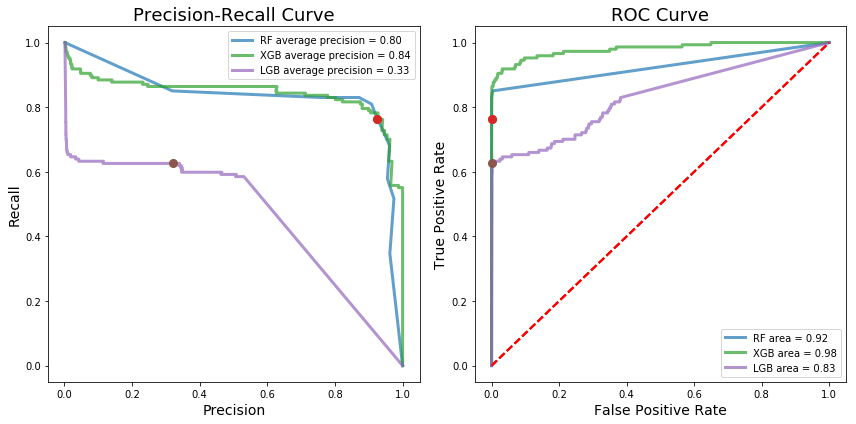

In [14]:
results("Without Balancing")

### Main notions about the graphs
- ROC and AUC
The function takes both the true outcomes (0,1) from the test set and the predicted probabilities for the 1 class. The function returns the false positive rates for each threshold, true positive rates for each threshold and thresholds.
- Precision-Recall Curves
Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value. The precision and recall can be calculated for thresholds using the precision_recall_curve() function that takes the true output values and the probabilities for the positive class as input and returns the precision, recall and threshold values.

## Insights from the graphs above
1. Average precision calculated here is the area under the precision-recall curve which is also called as average precision.
2. The dot in the graph are the default threshold values which is always equal to 0.5 for trees.

#### Results:
1. As expected, xgboost performed well for imbalanced dataset as boosting methods provide higher weights to minority classes. 
2. Besides, for highly imbalanced data, even Random forest performed well (which was beyond my expectations).
3. Now, comparing results of RF and XGB, both performed almost same. But there is quite difference between ROC AUC between both. One of the reason for this may be due to the less number of thresholds present in RF.
4. Surprisingly, LGB performed very bad. This may be due to the default parameters present as LGB is quite sensitive to parameter setting.

### NOTE:
Area using model function (roc_auc_score) and area from compare_models function (roc_curve) are different. This is because y_pred with roc_aur_score and y_pred_prob with roc_curve used together accordingly. Using y_pred_prob is preffered because it increases the number of thresholds (so that more points are available to plot the graph accurately) whereas y_pred will only give 3 threshold(0, 1, and any value in between 0 and 1).

# Data Balancing Techniques

### 1. Down-Sampling

As mentioned above, one of the options to deal with unbalanced dataset is downsampling. Which means resizing one class to other's size by dropping some observation to reach the same size.

In [15]:
print("Minority Class =", len(df[df.Class == 1]))

Minority Class = 492


In [16]:
train_majority = df[df.Class == 0]
train_minority = df[df.Class == 1]
train_majority_downsampled = resample(train_majority, replace = False, n_samples = 492, random_state = 0)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

Splitting the downsampled dataset into train and test sets for models.

In [17]:
X = train_downsampled.drop(columns = 'Class')
y = train_downsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Although pudated dataset is balanced and boosting models will not give higher weights to the fraulent class, it is important to chech if it performs well on a balanced dataset.

Down Sampling
######################### RF #########################
Training Accuracy = 0.993
Test Accuracy = 0.922
ROC_AUC_score : 0.922545
[[141   6]
 [ 17 132]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.89      0.96      0.92       147
          1       0.96      0.89      0.92       149

avg / total       0.92      0.92      0.92       296

######################### XGB #########################
Training Accuracy = 0.999
Test Accuracy = 0.939
ROC_AUC_score : 0.939369
[[142   5]
 [ 13 136]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       147
          1       0.96      0.91      0.94       149

avg / total       0.94      0.94      0.94       296

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.926
ROC_AUC_score : 0.925946
[[142   5]
 [ 17

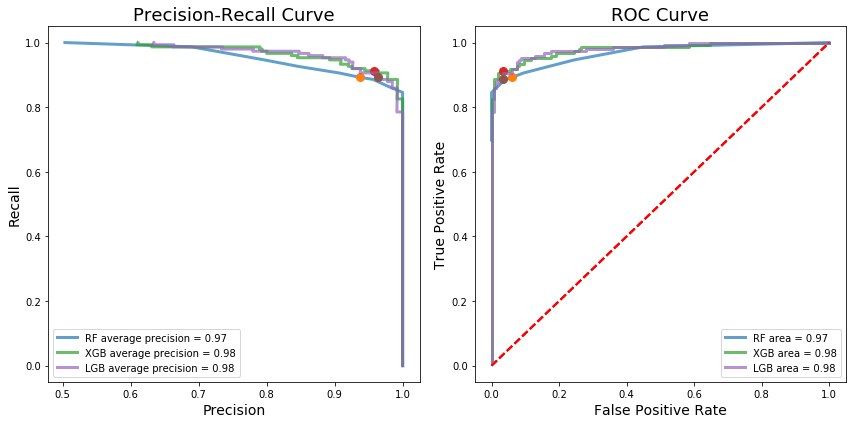

In [18]:
results("Down Sampling")

1. All models performed well but the main disadvantage of down sampling is that it will lose a lot of useful information from the dataset as it is removing more than 99% of non-fraudulent cases from the dataset. Thus, this should not be a practical approach here.

### 2. Up-Sampling

The other option to deal with unbalanced dataset is upsampling which is basically the opposite of the downsampling, in other words, upsampling is a procedure where synthetically generated data points (corresponding to minority class) are injected into the dataset. After this process, the counts of both labels are almost the same. This equalization procedure prevents the model from inclining towards the majority class.

In [19]:
#Note in up sampling, first split the minority class data into train and test set and then up-sample the train data and test it with test data
X = df.drop(columns = 'Class')
y = df['Class']
#First split data into train and test
X_train_us, X_test, y_train_us, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
#Now resample the train data
df_us = pd.concat([X_train_us, y_train_us], axis = 1)
train_majority = df_us[df_us.Class == 0]
train_minority = df_us[df_us.Class == 1]
train_majority.shape, train_minority.shape

((199019, 30), (345, 30))

In [20]:
train_minority_upsampled = resample(train_minority, replace = True, n_samples = 199019, random_state = 0)
print(train_majority.shape, train_minority_upsampled.shape)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
X_train = train_upsampled.drop(columns = 'Class')
y_train = train_upsampled['Class']

(199019, 30) (199019, 30)


Up Sampling
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 1.000
ROC_AUC_score : 0.877528
[[85292     4]
 [   36   111]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.97      0.76      0.85       147

avg / total       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 0.998
Test Accuracy = 0.996
ROC_AUC_score : 0.933346
[[84950   346]
 [   19   128]]
--------------- CLASSIFICATION REPORT ---------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.27      0.87      0.41       147

avg / total       1.00      1.00      1.00     85443

######################### LGB #########################
Training Accuracy = 1.000
Test Accuracy = 0.999
ROC_AUC_score : 0.908058
[[

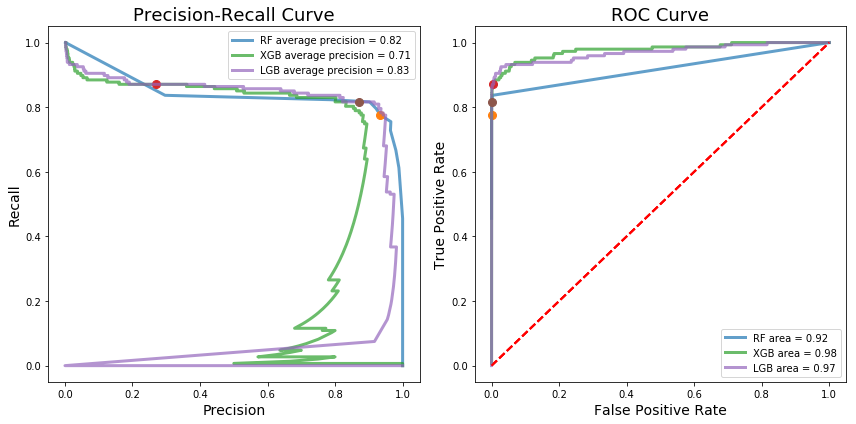

In [21]:
results("Up Sampling")

1. Surprisingly, threshold of XGB is very earlier. But, PR curves resembles same as other models. This means using up sampling, XGB performs well on recall but precision is decreased. Which means that XGB classified less FN and more FP with more than 50% probability. Thus, this increases the recall of XGB.
2. Further looking at PR curves, it is possible to decut that all models performes well. As per requirement, one can set threshold and get the required result.

Now, the down side of this method here is up-sampling will restrict learning of models due to repeatation of fraudulent cases so many times and eventually will overfit also. Also it costs us very expensive computationally.

##### CONCLUSION:
1. ROC curve for all three models were almost same. PR curve however differentiated somewhat performance based on precision.
2. Random forest performed best when data was balanced with different techniques as it maintained recall and precision with the default threshold and maintained precision as compared to boosting as the threshold was decreasing.
3. For imbalanced data XGB performed slightly well as compared to RF.
4. For balanced data, boosting made predictions with high recall and compromising precision and RF made predictions based on both recall and precision.
5. From PR curves, it is possible to say that models performed well. User can set threshold to obtain the required result.